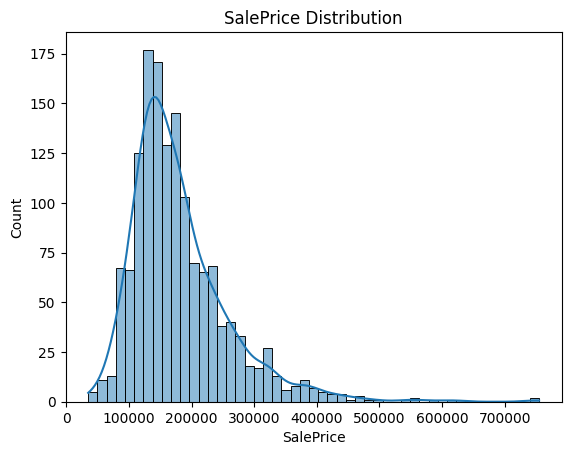

In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

sns.histplot(train['SalePrice'], kde=True)
plt.title("SalePrice Distribution")
plt.show()


In [9]:
cols_drop = ['Id', 'Utilities', 'Street', 'Alley', 'PoolQC', 'Fence', 'MiscFeature']
train = train.drop(cols_drop, axis=1)
test = test.drop(cols_drop, axis=1)

cat_cols = train.select_dtypes(include=['object']).columns
num_cols = train.select_dtypes(include=['number']).drop('SalePrice', axis=1).columns
train[cat_cols] = train[cat_cols].fillna('Missing')
train[num_cols] = train[num_cols].fillna(train[num_cols].median())


In [10]:
X = train.drop('SalePrice', axis=1)
y = train['SalePrice']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols) # Removed sparse=False
])

models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

RandomForest RMSE: 29273.20


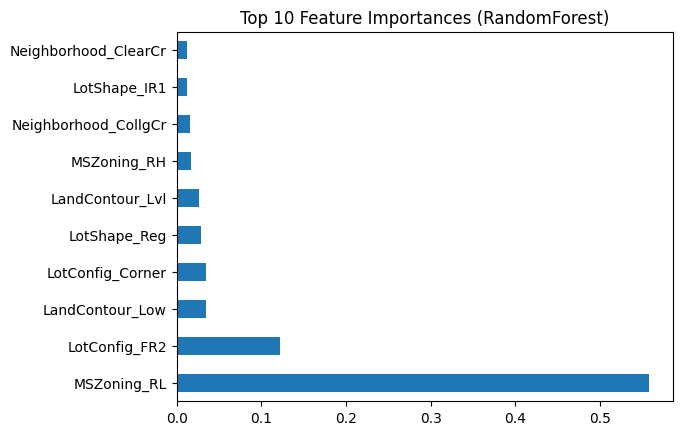

XGBoost RMSE: 26113.15


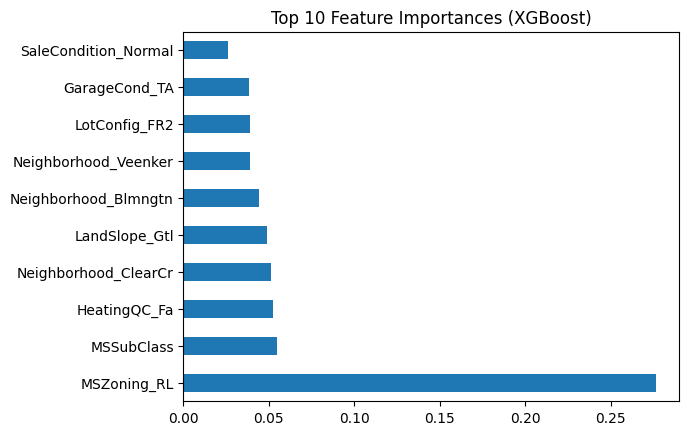

In [11]:
for name, model in models.items():
    pipe = Pipeline([('pre', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    print(f"{name} RMSE: {rmse:.2f}")
    if hasattr(model, 'feature_importances_'):
        imp = model.feature_importances_
        feat_names = preprocessor.transformers_[1][1].get_feature_names_out(cat_cols).tolist() + num_cols.tolist()
        top_imp = pd.Series(imp, index=feat_names).nlargest(10)
        top_imp.plot(kind='barh', title=f"Top 10 Feature Importances ({name})")
        plt.show()


# Hyperparameter Tuning (using GridSearchCV for XGBoost)

In [12]:
from sklearn.model_selection import GridSearchCV

xgb_pipe = Pipeline([
    ('pre', preprocessor),
    ('model', XGBRegressor(random_state=42, verbosity=0))
])

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2]
}

grid = GridSearchCV(xgb_pipe, param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best RMSE: {-grid.best_score_:.2f}")
print("Best Params:", grid.best_params_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best RMSE: 27412.57
Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}


# Other Models (Lasso & LightGBM)

In [13]:
from sklearn.linear_model import Lasso
from lightgbm import LGBMRegressor

models.update({
    'Lasso': Lasso(alpha=1.0),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42)
})

for name, model in models.items():
    pipe = Pipeline([('pre', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    print(f"{name} RMSE: {rmse:.2f}")


RandomForest RMSE: 29273.20
XGBoost RMSE: 26113.15


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36412627671.33496, tolerance: 696659484.3571944
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Lasso RMSE: 28534.72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3215
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 184
[LightGBM] [Info] Start training from score 181441.541952
LightGBM RMSE: 29353.80


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# Ensemble Stacking (Combine Top Models)

In [14]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

estimators = [
    ('xgb', XGBRegressor(n_estimators=100, random_state=42, verbosity=0)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('lgb', LGBMRegressor(n_estimators=100, random_state=42))
]

stack = StackingRegressor(estimators=estimators, final_estimator=Ridge())

stack_pipe = Pipeline([('pre', preprocessor), ('model', stack)])
stack_pipe.fit(X_train, y_train)
pred = stack_pipe.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, pred))
print(f"Stacking Ensemble RMSE: {rmse:.2f}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3215
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 184
[LightGBM] [Info] Start training from score 181441.541952


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3039
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 175
[LightGBM] [Info] Start training from score 181121.274090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3024
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 170
[LightGBM] [Info] Start training from score 179912.635974


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3029
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 170
[LightGBM] [Info] Start training from score 182516.069593
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3032
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 173
[LightGBM] [Info] Start training from score 182235.731551


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3034
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 173
[LightGBM] [Info] Start training from score 181421.170053
Stacking Ensemble RMSE: 27818.98


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


RMSE: 28969.60


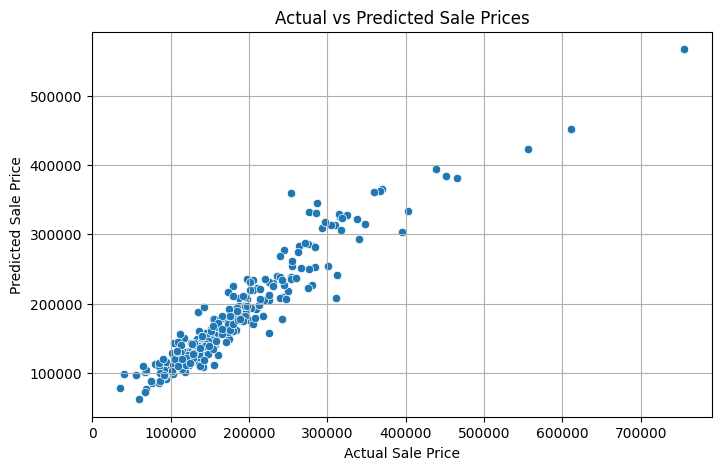

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/train.csv")

df.drop(columns=['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature'], inplace=True)

num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna('Missing')

X = df.drop('SalePrice', axis=1)
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), X.select_dtypes(include=['int64', 'float64']).columns),
    ('cat', OneHotEncoder(handle_unknown='ignore'), X.select_dtypes(include=['object']).columns)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

model.fit(X_train, y_train)

predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse:.2f}")

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=predictions)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs Predicted Sale Prices")
plt.grid(True)
plt.show()